# How to pass config to tools

<div class="admonition tip">
    <p class="admonition-title">Prerequisites</p>
    <p>
        This guide assumes familiarity with the following:
        <ul>
            <li>
                <a href="https://python.langchain.com/docs/concepts/#runnable-interface">
                    Runnable Interface
                </a>
            </li>
            <li>
                <a href=" https://langchain-ai.github.io/langgraph/concepts/agentic_concepts/#tool-calling-agent">
                    Tool calling agent
                </a>
            </li>      
            <li>
                <a href="https://python.langchain.com/docs/concepts/#tools">
                    Tools
                </a>
            </li>
            <li>
                <a href="https://langchain-ai.github.io/langgraph/concepts/streaming/">
                    Streaming
                </a>
            </li>            
            <li>
                <a href="https://python.langchain.com/docs/concepts/#chat-models/">
                    Chat Models
                </a>
            </li>
        </ul>
    </p>
</div> 



At runtime, you may need to pass values to a tool, like a user ID, which should be set by the application logic, not controlled by the LLM, for security reasons. The LLM should only manage its intended parameters.

LangChain tools use the `Runnable` interface, where methods like `invoke` accept runtime information through the config argument with a `RunnableConfig` type annotation.

In the following example, we’ll set up an agent with tools to manage a user's favorite pets—adding, reading, and deleting entries—while fixing the user ID through application logic and letting the chat model control other parameters

## Setup

First, let's install the required packages and set our API keys

In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_anthropic

In [ ]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("ANTHROPIC_API_KEY")

<div class="admonition tip">
    <p class="admonition-title">Set up <a href="https://smith.langchain.com">LangSmith</a> for LangGraph development</p>
    <p style="padding-top: 5px;">
        Sign up for LangSmith to quickly spot issues and improve the performance of your LangGraph projects. LangSmith lets you use trace data to debug, test, and monitor your LLM apps built with LangGraph — read more about how to get started <a href="https://docs.smith.langchain.com">here</a>. 
    </p>
</div>

## Define tools and model

!!! warning "Config type annotations"

    Each tool function can take a `config` argument. In order for the config to be correctly propagated to the function, you MUST always add a `RunnableConfig` type annotation for your `config` argument. For example:

    ```python
    def my_tool(tool_arg: str, config: RunnableConfig):
        ...
    ```

In [3]:
from typing import List

from langchain_core.tools import tool
from langchain_core.runnables.config import RunnableConfig

from langgraph.prebuilt import ToolNode

user_to_pets = {}


@tool(parse_docstring=True)
def update_favorite_pets(
    # NOTE: config arg does not need to be added to docstring, as we don't want it to be included in the function signature attached to the LLM
    pets: List[str],
    config: RunnableConfig,
) -> None:
    """Add the list of favorite pets.

    Args:
        pets: List of favorite pets to set.
    """
    user_id = config.get("configurable", {}).get("user_id")
    user_to_pets[user_id] = pets


@tool
def delete_favorite_pets(config: RunnableConfig) -> None:
    """Delete the list of favorite pets."""
    user_id = config.get("configurable", {}).get("user_id")
    if user_id in user_to_pets:
        del user_to_pets[user_id]


@tool
def list_favorite_pets(config: RunnableConfig) -> None:
    """List favorite pets if asked to."""
    user_id = config.get("configurable", {}).get("user_id")
    return ", ".join(user_to_pets.get(user_id, []))


tools = [update_favorite_pets, delete_favorite_pets, list_favorite_pets]

We'll be using a small chat model from Anthropic in our example.

In [4]:
from langchain_anthropic import ChatAnthropic
from langgraph.graph import StateGraph, MessagesState
from langgraph.prebuilt import ToolNode


model = ChatAnthropic(model="claude-3-5-haiku-latest")

## ReAct Agent

Let's set up a graph implementation of the [ReAct agent](https://langchain-ai.github.io/langgraph/concepts/agentic_concepts/#react-agent). This agent takes some query as input, then repeatedly call tools until it has enough information to resolve the query. We'll be using prebuilt [`create_react_agent`][langgraph.prebuilt.chat_agent_executor.create_react_agent] and the Anthropic model with tools we just defined. Note: the tools are automatically added to the model via `model.bind_tools` inside the `create_react_agent` implementation.

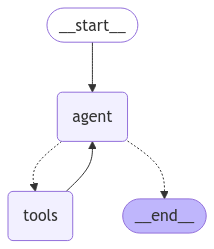

In [5]:
from langgraph.prebuilt import create_react_agent
from IPython.display import Image, display

graph = create_react_agent(model, tools)

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

## Use it!

In [6]:
from langchain_core.messages import HumanMessage

user_to_pets.clear()  # Clear the state

print(f"User information prior to run: {user_to_pets}")

inputs = {"messages": [HumanMessage(content="my favorite pets are cats and dogs")]}
for chunk in graph.stream(
    inputs, {"configurable": {"user_id": "123"}}, stream_mode="values"
):
    chunk["messages"][-1].pretty_print()

print(f"User information after the run: {user_to_pets}")

User information prior to run: {}
================================ Human Message =================================

my favorite pets are cats and dogs
================================== Ai Message ==================================

[{'text': "I'll help you update your favorite pets using the `update_favorite_pets` function.", 'type': 'text'}, {'id': 'toolu_015jtecJ4jnosAfXEC3KADS2', 'input': {'pets': ['cats', 'dogs']}, 'name': 'update_favorite_pets', 'type': 'tool_use'}]
Tool Calls:
  update_favorite_pets (toolu_015jtecJ4jnosAfXEC3KADS2)
 Call ID: toolu_015jtecJ4jnosAfXEC3KADS2
  Args:
    pets: ['cats', 'dogs']
================================= Tool Message =================================
Name: update_favorite_pets

null
================================== Ai Message ==================================

Great! I've added cats and dogs to your list of favorite pets. Would you like to confirm the list or do anything else with it?
User information after the run: {'123': ['cats', 'dogs']

In [7]:
from langchain_core.messages import HumanMessage

print(f"User information prior to run: {user_to_pets}")

inputs = {"messages": [HumanMessage(content="what are my favorite pets")]}
for chunk in graph.stream(
    inputs, {"configurable": {"user_id": "123"}}, stream_mode="values"
):
    chunk["messages"][-1].pretty_print()

print(f"User information prior to run: {user_to_pets}")

User information prior to run: {'123': ['cats', 'dogs']}
================================ Human Message =================================

what are my favorite pets
================================== Ai Message ==================================

[{'text': "I'll help you check your favorite pets by using the list_favorite_pets function.", 'type': 'text'}, {'id': 'toolu_01EMTtX5WtKJXMJ4WqXpxPUw', 'input': {}, 'name': 'list_favorite_pets', 'type': 'tool_use'}]
Tool Calls:
  list_favorite_pets (toolu_01EMTtX5WtKJXMJ4WqXpxPUw)
 Call ID: toolu_01EMTtX5WtKJXMJ4WqXpxPUw
  Args:
================================= Tool Message =================================
Name: list_favorite_pets

cats, dogs
================================== Ai Message ==================================

Based on the results, your favorite pets are cats and dogs.

Is there anything else you'd like to know about your favorite pets, or would you like to update the list?
User information prior to run: {'123': ['cats', 'dogs']

In [8]:
print(f"User information prior to run: {user_to_pets}")

inputs = {
    "messages": [
        HumanMessage(content="please forget what i told you about my favorite animals")
    ]
}
for chunk in graph.stream(
    inputs, {"configurable": {"user_id": "123"}}, stream_mode="values"
):
    chunk["messages"][-1].pretty_print()

print(f"User information prior to run: {user_to_pets}")

User information prior to run: {'123': ['cats', 'dogs']}
================================ Human Message =================================

please forget what i told you about my favorite animals
================================== Ai Message ==================================

[{'text': "I'll help you delete the list of favorite pets. I'll use the delete_favorite_pets function to remove any previously saved list.", 'type': 'text'}, {'id': 'toolu_01JqpxgxdsDJFMzSLeogoRtG', 'input': {}, 'name': 'delete_favorite_pets', 'type': 'tool_use'}]
Tool Calls:
  delete_favorite_pets (toolu_01JqpxgxdsDJFMzSLeogoRtG)
 Call ID: toolu_01JqpxgxdsDJFMzSLeogoRtG
  Args:
================================= Tool Message =================================
Name: delete_favorite_pets

null
================================== Ai Message ==================================

The list of favorite pets has been deleted. If you'd like to create a new list of favorite pets in the future, just let me know.
User information